# Home Assignment No. 3

To solve this task, you will write a lot of code to try several machine learning methods for classification and regression.
* You are **HIGHLY RECOMMENDED** to read relevant documentation, e.g. for [python](https://docs.python.org/3/), [numpy](https://docs.scipy.org/doc/numpy/reference/), [matlpotlib](https://matplotlib.org/) and [sklearn](https://scikit-learn.org/stable/). Also remember that seminars, lecture slides, [Google](http://google.com) and [StackOverflow](https://stackoverflow.com/) are your close friends during this course (and, probably, whole life?).

* If you want an easy life, you have to use **BUILT-IN METHODS** of `sklearn` library instead of writing tons of your own code. There exists a class/method for almost everything you can imagine (related to this homework).

* You have to write **CODE** directly inside specified places marked by comments: **BEGIN/END Solution**. Do not create new cells.

* In some problems you are asked to provide a short discussion of the results. For that find the specific place marked via **Your text answer: \<write your answer\>**.

* For every separate problem or subproblem (if specified) you can get only 0 points or maximal points for this problem. There are **NO INTERMEDIATE scores**. So make sure that you did everything required in the task.

* Your **SOLUTION** notebook **MUST BE REPRODUCIBLE**, i.e., if the reviewer decides to restart the notebook and run all cells, after all the computation he will obtain exactly the same solution (with all the corresponding plots) as in your uploaded notebook. For this purpose, we suggest fixing random `seed` or (better) define `random_state=` inside every algorithm that uses some pseudorandomness.

* Your code must be clear to the reviewer. For this purpose, try to include necessary comments inside the code. But remember: **GOOD CODE MUST BE SELF-EXPLANATORY** without any additional comments.

* Many `sklearn` algorithms support multithreading (Ensemble Methods, Cross-Validation, etc.). Check if the particular algorithm has `n_jobs` parameters and set it to `-1` to use all the cores.


In [ ]:
# Your imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import GPy
import statsmodels.api as sm
from sklearn.metrics import r2_score

from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score, mutual_info_score
from sklearn.ensemble import IsolationForest 
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

from sklearn.cluster import Birch, AgglomerativeClustering
from matplotlib.gridspec import SubplotSpec
import scipy
from scipy import stats

import warnings
warnings.filterwarnings("ignore")


## Task 1 - Gaussian Processes (1 pt.)

In the following exercise, you will need to fit the gaussian process with different kernels on the ```elecricity_consumption_FR.csv``` time series data. We have already loaded and prepared the train/test datasets for you below.

Use [**GPy**](https://pypi.python.org/pypi/GPy) library for training and prediction. Fit a GP and run the predict on the test. Useful kernels to combine: `GPy.kern.RBF, GPy.kern.Poly, GPy.kern.StdPeriodic, GPy.kern.White, GPy.kern.Linear`. 

**The task**:
* Normalize the target value by fitting a transformation on the train (use ```sklearn.preprocessing.StandardScaler```)
* Plot the resulting target against the time index.
* Plot mean and confidence interval of the prediction. 
* Inspect them on normality by scatter plot: plot predicted points/time series against true values. 
* Estimate the prediction error with `r2_score`. R2-score accepted > 0.7 on test sample.

In [ ]:
! pip install GPy==1.9.9

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

In [4]:
data = pd.read_csv('elecricity_consumption_FR.csv')

In [5]:
data.dropna(inplace=True)

In [6]:
y = np.array(data.values)
X = np.array(data.index)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.3)
X_train = X_train.reshape(-1,1)
X_test = X_test.reshape(-1,1)


Normalize the target value by fitting a transformation on the train (use sklearn.preprocessing.StandardScaler)

In [8]:
### BEGIN SOLUTION (do not delete this comment!)

scaler = StandardScaler()
scaler.fit(y_train)

y_train_scale = scaler.transform(y_train)
y_test_scale = scaler.transform(y_test)
y_scale = scaler.transform(y)

### END SOLUTION (do not delete this comment!)

Plot the resulting target against the time index.

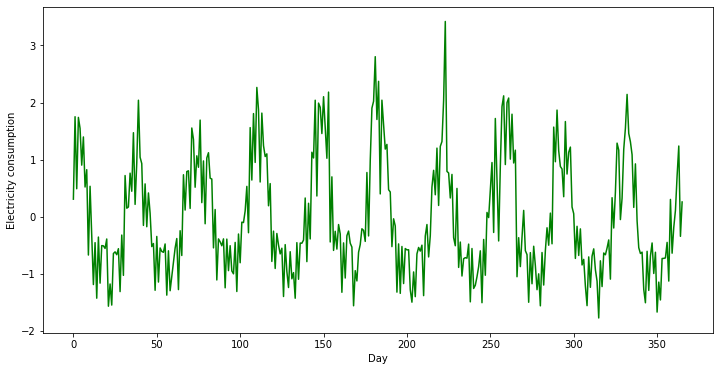

In [9]:
### BEGIN SOLUTION (do not delete this comment!)
  
plt.figure(figsize=(12, 6))
plt.plot(X, y_scale, color='g')
plt.xlabel("Day")
plt.ylabel("Electricity consumption");
    
### END SOLUTION (do not delete this comment!)

Plot mean and confidence interval of the prediction.

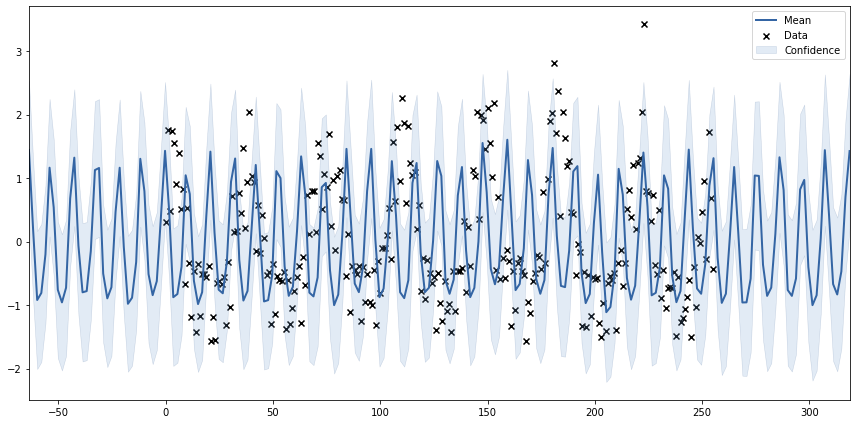

In [10]:
### BEGIN SOLUTION (do not delete this comment!)

k_trend = GPy.kern.Poly(input_dim=1, variance=1, order=1) * GPy.kern.RBF(input_dim=1, variance=1, lengthscale=7)
k_seasonality = GPy.kern.StdPeriodic(input_dim=1, variance=1, lengthscale=0.2) 

k = k_trend + k_seasonality 

model = GPy.models.GPRegression(X_train, y_train_scale, k)

model.optimize()
model.plot(figsize=(12, 6));

### END SOLUTION (do not delete this comment!))

Inspect them on normality by scatter plot: plot predicted points/time series against true values.

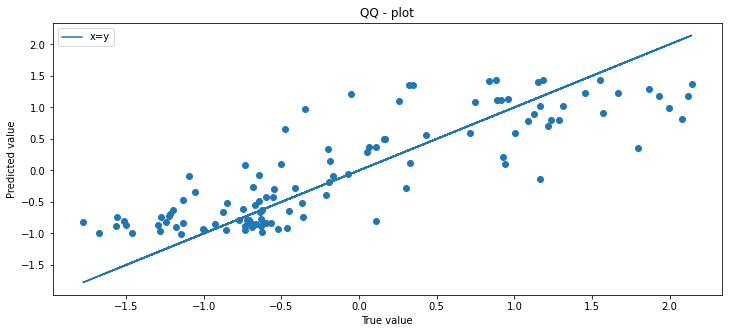

In [11]:

### BEGIN SOLUTION (do not delete this comment!)

y_pred = model.predict(X_test)[0]

plt.figure(figsize=(12, 5))

plt.scatter(y_test_scale, y_pred)
plt.plot(y_test_scale, y_test_scale, label = 'x=y')

plt.title('QQ - plot')
plt.xlabel('True value')
plt.ylabel('Predicted value')
plt.legend()
plt.show()

### END SOLUTION (do not delete this comment!)

Estimate the prediction error with r2_score. R2-score accepted > 0.7 on test sample.

In [12]:
### BEGIN SOLUTION (do not delete this comment!)

r2_score(y_test_scale, y_pred)

### END SOLUTION (do not delete this comment!)

0.7110359656019262

## Task 2 - MNIST, kMNIST component analysis and manifold learning. (5 pts.)

### Task 2.1. (1 pt)

Download `MNIST` dataset. Here we will estimate the data intrinsic dimensionality, decompose the dataset on principle components and estimate the cumulative explained variance by each component.

You can either use the [proposed method](https://www.stat.berkeley.edu/~bickel/mldim.pdf) for the estimation of sample intrinsic dimension or any other method (convenient for you). For the first case, yoyu may use the code from [here](https://gist.github.com/mehdidc/8a0bb21a31c43b0cbbdd31d75929b5e4)

1. Estimate the intrinsic dimensionality of the dataset. Provide the plot.
2. Decompose the data on principal components (PCA). Plot the cumulative explained variance by each component. Plot the example of back-decomposition with **6** different set of components and corresponding explained variance. You can choose any digit from the dataset.

In [13]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

dg = datasets.load_digits()

scaler = StandardScaler().fit(dg.data)
data = scaler.transform(dg.data)

1) Estimate the intrinsic dimentionality of the dataset. Provide the plot.

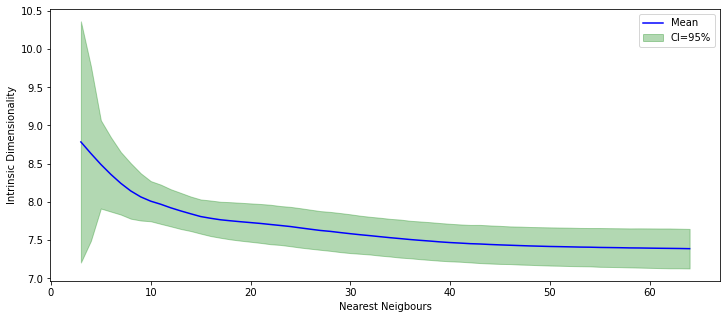

In [14]:
### BEGIN SOLUTION (do not delete this comment!)

# Code from : https://gist.github.com/mehdidc/8a0bb21a31c43b0cbbdd31d75929b5e4

def intrinsic_dim_sample_wise(X, k=5):
    neighb = NearestNeighbors(n_neighbors=k + 1).fit(X)
    dist, ind = neighb.kneighbors(X)
    dist = dist[:, 1:]
    dist = dist[:, 0:k]
    assert dist.shape == (X.shape[0], k)
    assert np.all(dist > 0)
    d = np.log(dist[:, k - 1: k] / dist[:, 0:k-1])
    d = d.sum(axis=1) / (k - 2)
    d = 1. / d
    intdim_sample = d
    return intdim_sample

def intrinsic_dim_scale_interval(X, k1=10, k2=20):
    X = pd.DataFrame(X).drop_duplicates().values # remove duplicates in case you use bootstrapping
    intdim_k = []
    for k in range(k1, k2 + 1):
        m = intrinsic_dim_sample_wise(X, k).mean()
        intdim_k.append(m)
    return intdim_k

def repeated(func, X, nb_iter=100, random_state=None, verbose=0, mode='bootstrap', **func_kw):
    if random_state is None:
        rng = np.random
    else:
        rng = np.random.RandomState(random_state)
    nb_examples = X.shape[0]
    results = []

    iters = range(nb_iter)
    if verbose > 0:
        iters = tqdm(iters)    
    for i in iters:
        if mode == 'bootstrap':
            Xr = X[rng.randint(0, nb_examples, size=nb_examples)]
        elif mode == 'shuffle':
            ind = np.arange(nb_examples)
            rng.shuffle(ind)
            Xr = X[ind]
        elif mode == 'same':
            Xr = X
        else:
            raise ValueError('unknown mode : {}'.format(mode))
        results.append(func(Xr, **func_kw))
    return results

# Estimate the intrinsic dimentionality and plot

k1 = 3
k2 = data.shape[1]
nb_iter = 100

intdim_k_repeated = repeated(intrinsic_dim_scale_interval, 
                             data,
                             nb_iter = nb_iter,
                             random_state=0,
                             mode='bootstrap',                             
                             k1=k1, k2=k2)
intdim_k_repeated = np.array(intdim_k_repeated)

x = np.arange(k1, k2 + 1)

plt.figure(figsize=(12, 5))
plt.plot(x, np.mean(intdim_k_repeated, axis=0), 'b', label='Mean')
plt.fill_between(x, 
                 np.mean(intdim_k_repeated, axis=0) - 2 * np.std(intdim_k_repeated, axis=0),
                 np.mean(intdim_k_repeated, axis=0) + 2 * np.std(intdim_k_repeated, axis=0),
                 alpha=0.3,
                 label='CI=95%',
                 color='g')
plt.xlabel("Nearest Neigbours")
plt.ylabel("Intrinsic Dimensionality")
plt.legend()
plt.show()

### END SOLUTION (do not delete this comment!)

2) Decompose the data on principal components (PCA). Plot the cumulative explained variance by each component. Plot the example of back-decomposition with 6 different set of components and corresponding explained variance. You can choose any digit from the dataset.

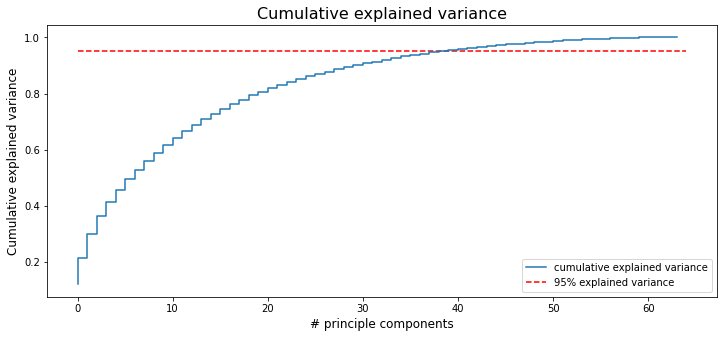

In [15]:
### BEGIN SOLUTION (do not delete this comment!)

pca = PCA().fit(data)

plt.figure(figsize=(12, 5))
plt.step(range(len(pca.components_)), 
         np.cumsum(pca.explained_variance_ratio_), 
         label='cumulative explained variance')

plt.title('Cumulative explained variance', fontsize=16)
plt.xlabel('# principle components', fontsize=12)
plt.ylabel('Cumulative explained variance', fontsize=12)

plt.hlines(y=0.95, xmin=0, xmax= len(pca.components_), colors='r', linestyles='dashed', label='95% explained variance')
plt.legend(loc='lower right')
plt.show()

### END SOLUTION (do not delete this comment!)

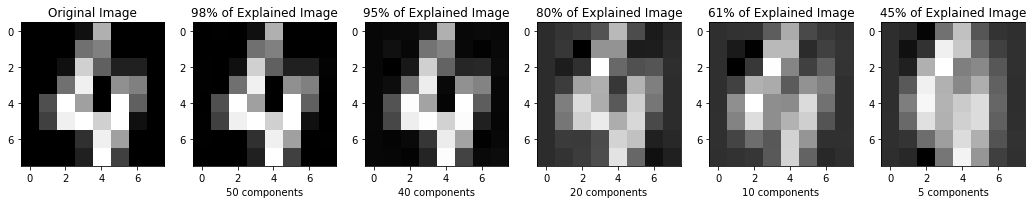

In [ ]:
### BEGIN SOLUTION (do not delete this comment!)

component = [50, 40, 20, 10, 5]
var_ratio = [0.98, 0.95, 0.80, 0.61, 0.45]

def dg_inv_trans(i, data):
  n_comp = (np.where(np.cumsum(pca.explained_variance_ratio_) > var_ratio[i])[0][0]) + 1
  pca_new = PCA(n_comp)
  data_fit_trans = pca_new.fit_transform(data)
  data_inv_trans = pca_new.inverse_transform(data_fit_trans)
  return data_inv_trans

fig, ax = plt.subplots(ncols=6, nrows=1, figsize=(18, 3))

ax[0].imshow(dg.data[4].reshape(8, 8), cmap='gray', interpolation='nearest')
ax[0].set_title('Original Image')

for i in range(0, 5):
  ax[i+1].imshow(dg_inv_trans(i, dg.data)[4].reshape(8, 8), cmap='gray', interpolation='nearest')
  ax[i+1].set_title(f'{round(var_ratio[i]*100)}% of Explained Image')
  ax[i+1].set_xlabel(f'{component[i]} components')

### END SOLUTION (do not delete this comment!)


### Task 2.2. (1 pt.)

Here we will visualize the decomposition in order to observe how data diverges across different manifold learning methods. We are to compare `PCA`, `ICA` and `Isomap` non-linear decompositions [see more over here https://scikit-learn.org/stable/modules/manifold.html], and check the classification accuracy on the new features. 

1. Calculate new features on the data with ICA, PCA and Isomap. **Choose the number of components according to your estimation of intrinsic dimension**. Calculate the classification accuracy on these features with `LogisticRegression` on `cross_val=5` with $3$ repeats. Use `RepeatedKFold` and fit the `random_seed = 42`.
2. Show that the `Isomap` gives a statistically significant improvement on the classification accuracy with any appropriate statistical test. Provide corresponding `p-values`. Justify your results, write down 2-3 sentences.


In [16]:
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from scipy import stats
from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import Isomap

1) Calculate new features on the data with ICA, PCA and Isomap. Choose the number of components according to your estimation of intrinsic dimention. Calculate the classification accuracy on these features with LogisticRegression on cross_val=5 with  3  repeats. Use RepeatedKFold and fit the random_seed = 42.

In [ ]:
### BEGIN SOLUTION (do not delete this comment!)

X_pca = PCA(n_components=40).fit_transform(data)
X_ica = FastICA(n_components=40).fit_transform(data)
X_iso = Isomap(n_components=40).fit_transform(data)

cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
clf = LogisticRegression(random_state=42)

score_pca = cross_val_score(clf, X_pca, dg.target, scoring='accuracy', cv=cv)
score_ica = cross_val_score(clf, X_ica, dg.target, scoring='accuracy', cv=cv)
score_iso = cross_val_score(clf, X_iso, dg.target, scoring='accuracy', cv=cv)

print(f'PCA: {score_pca.mean()}')
print(f'FastICA: {score_ica.mean()}')
print(f'Isomap: {score_iso.mean()}')

### END SOLUTION (do not delete this comment!)


PCA: 0.9627138140926443
FastICA: 0.9115139791602187
Isomap: 0.9645687609615187


2) Show that the `Isomap` gives statistically significant improvement on the classification accuracy with any appropriate statistical test. Provide corresponding `p-values`. 

In [ ]:
### BEGIN SOLUTION (do not delete this comment!)

stat_1 = stats.ttest_ind(score_iso, score_pca).statistic
pval_1 = stats.ttest_ind(score_iso, score_pca).pvalue

stat_2 = stats.ttest_ind(score_iso, score_ica).statistic
pval_2 = stats.ttest_ind(score_iso, score_ica).pvalue

print('T test with alternative hypothesis that Isomap has greater accuracy than PCA')
print(f'Statistic: {stat_1} p_value: {pval_1}')

print('T test with alternative hypothesis that Isomap has greater accuracy than FastICA')
print(f'Statistic: {stat_2} p_value: {pval_2}')

### END SOLUTION (do not delete this comment!)

T test with alternative hypothesis that Isomap has greater accuracy than PCA
Statistic: 0.49757789689084053 p_value: 0.6226668475385935
T test with alternative hypothesis that Isomap has greater accuracy than FastICA
Statistic: 9.42233201284675 p_value: 3.520362829948585e-10


### Task 2.3. (1 pt.)

3) Justify your results, write down 2-3 senteces.

*BEGIN SOLUTION (do not delete this comment!)*

Isomap gives a significant improvement on the classification accuracy. If we set the significant level = 0.05, p_value: 0.6227 > 0.05 so, we fail to reject null hypothesis and can be interpreted that there is no sufficient evidence to conclude that Isomap has greater accuracy than PCA. On the other hand, p_value: 3.5204e-10 < 0.05 so, we can reject null hypothesis and can be interpreted that there is sufficient evidence to conclude that Isomap has greater accuracy than FastICA.

*END SOLUTION (do not delete this comment!)*

### Task 2.4. kMNIST dimensionality reduction. (2 pts.)

Explore `KMNIST` dataset https://github.com/rois-codh/kmnist. You are to engineer new features (by using any familiar to you method of Manifold Learning) to increase the classification accuracy. Use the `KNN` classifier with any hyperparameters you like.

1. __(2 pt.)__ Get accuracy on `test_set` more than 93%`. 

**NOTE** that the data is rather heavy, thus your decomposition will take a while.

__Hint:__ Try to use dimensionality reduction methods, which yield better model performance on `MNIST`. These methods can compete with Autoencoders on `torch`. 

1) Get accuracy on test_set more than 93%.

In [ ]:
import numpy as np

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

def load(f):
    return np.load(f)['arr_0']

# Load the data
x_train = load('kmnist-train-imgs.npz')
x_test = load('kmnist-test-imgs.npz')
y_train = load('kmnist-train-labels.npz')
y_test = load('kmnist-test-labels.npz')

# Reshape the data
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

In [ ]:
### BEGIN SOLUTION (do not delete this comment!)

scaler = MinMaxScaler()
scaler.fit(x_train)
x_train_scale = scaler.transform(x_train)
x_test_scale = scaler.transform(x_test)

pca = PCA().fit(x_train_scale)

n_comp = (np.where(np.cumsum(pca.explained_variance_ratio_) > 0.75)[0][0]) + 1  # Select n_comp with cumulative explained variance > 75%

pca_new = PCA(n_components=n_comp)
pca_new.fit(x_train_scale)
x_train_pca = pca_new.transform(x_train_scale)
x_test_pca = pca_new.transform(x_test_scale)

knn = KNeighborsClassifier()
knn.fit(x_train_pca, y_train)
y_pred = knn.predict(x_test_pca)

accuracy = knn.score(x_test_pca, y_test)
print(f'Test accuracy: {accuracy}')

### END SOLUTION (do not delete this comment!)

Test accuracy: 0.9336


## Task 3 - Clustering (2 pts.)

### Task 3.1. Explore KMeans and Gaussian Mixture algorithms (1 pt.)

Try **KMeans, Gaussian Mixture** and **two** more clustering algorithms from sklearn. 
To evaluate clustering performance use **two** clustering metrics: *silhouette score*
and *mutual information* or *adjusted mutual information*.

For each algorithm **your task** is to try to find the parameters leading to the best performance for `n_clusters=true_number_of_clusters`:
1. Apply the algorithm with the true number of clusters and try out at least two **other variants** of the number of clusters: a smaller and a larger one than the true number.;
2. For each number of clusters **visualize the clustering result**, calculate the **clustering metrics** and plot them;

__NOTE:__ `sklearn.model_selection.GridSearchCV` does not support clustering methods, thus you suppose to do it manually.

In [17]:
import numpy as np

True number of clusters is 15


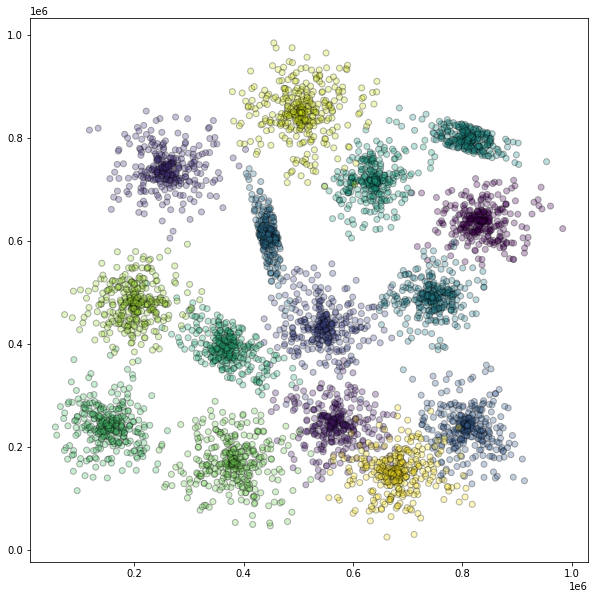

In [18]:
points, labels = np.loadtxt('clustering.txt'), np.loadtxt('clustering_labels.txt')
labels = labels.astype(int)
print("True number of clusters is {}".format(np.max(labels)))
plt.figure(figsize=(10, 10))
plt.scatter(points[:,0], points[:,1], c=labels, alpha=0.3, edgecolor='k')

plt.show()

In [19]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, mutual_info_score
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler

1) For each algorithm your task is to try to find the parameters leading to the best performance for n_clusters=true_number_of_clusters

In [20]:
### BEGIN SOLUTION (do not delete this comment!)

true_number_of_clusters = np.max(labels)

# Find the parameters leading to the best performance for n_clusters=true_number_of_clusters
params_used = []

algs = [KMeans(n_clusters = true_number_of_clusters, random_state = 0),
        GaussianMixture(n_components = true_number_of_clusters, random_state = 0),
        Birch(n_clusters = true_number_of_clusters),
        AgglomerativeClustering(n_clusters = true_number_of_clusters)]

param_grids = [{'init': ['k-means++', 'random'], 'max_iter': [100, 300, 500]},
               {'covariance_type': ['full', 'tied', 'diag', 'spherical'], 'max_iter': [100, 300, 500]},
               {'branching_factor': [20, 50, 100]},
               {'linkage': ['ward', 'complete', 'average', 'single']}]

# KMeans
km_param = param_grids[0]
p_0 = ParameterGrid(km_param)
silh_scores_0 = []
for i in range(0, len(list(p_0))):
  algs[0].set_params(**p_0[i])
  pred_target = algs[0].fit_predict(points)
  silh_scores_0.append(silhouette_score(points, pred_target))
index = np.argmax(silh_scores_0)
params_used.append(p_0[index])

# GaussianMixture
gs_param = param_grids[1]
p_1 = ParameterGrid(gs_param)
silh_scores_1 = []
for i in range(0, len(list(p_1))):
  algs[1].set_params(**p_1[i])
  pred_target = algs[1].fit_predict(points)
  silh_scores_1.append(silhouette_score(points, pred_target))
index = np.argmax(silh_scores_1)
params_used.append(p_1[index])

# Birch
gs_param = param_grids[2]
p_2 = ParameterGrid(gs_param)
silh_scores_2 = []
for i in range(0, len(list(p_2))):
  algs[2].set_params(**p_2[i])
  pred_target = algs[2].fit_predict(points)
  silh_scores_2.append(silhouette_score(points, pred_target))
index = np.argmax(silh_scores_2)
params_used.append(p_2[index])

# AgglomerativeClustering(n_clusters = true_number_of_clusters)]
gs_param = param_grids[3]
p_3 = ParameterGrid(gs_param)
silh_scores_3 = []
for i in range(0, len(list(p_3))):
  algs[3].set_params(**p_3[i])
  pred_target = algs[3].fit_predict(points)
  silh_scores_3.append(silhouette_score(points, pred_target))
index = np.argmax(silh_scores_3)
params_used.append(p_3[index])

### END SOLUTION (do not delete this comment!)

2) Apply the algorithm with the true number of clusters and try out at least two other variants of the number of clusters: a smaller and a larger one than the true number.;

 Do not forget that despite the plot picturing just the KMeans and GuassianMizture, you will need to ADDITIONALLY try put and plot two other clustering methods. 

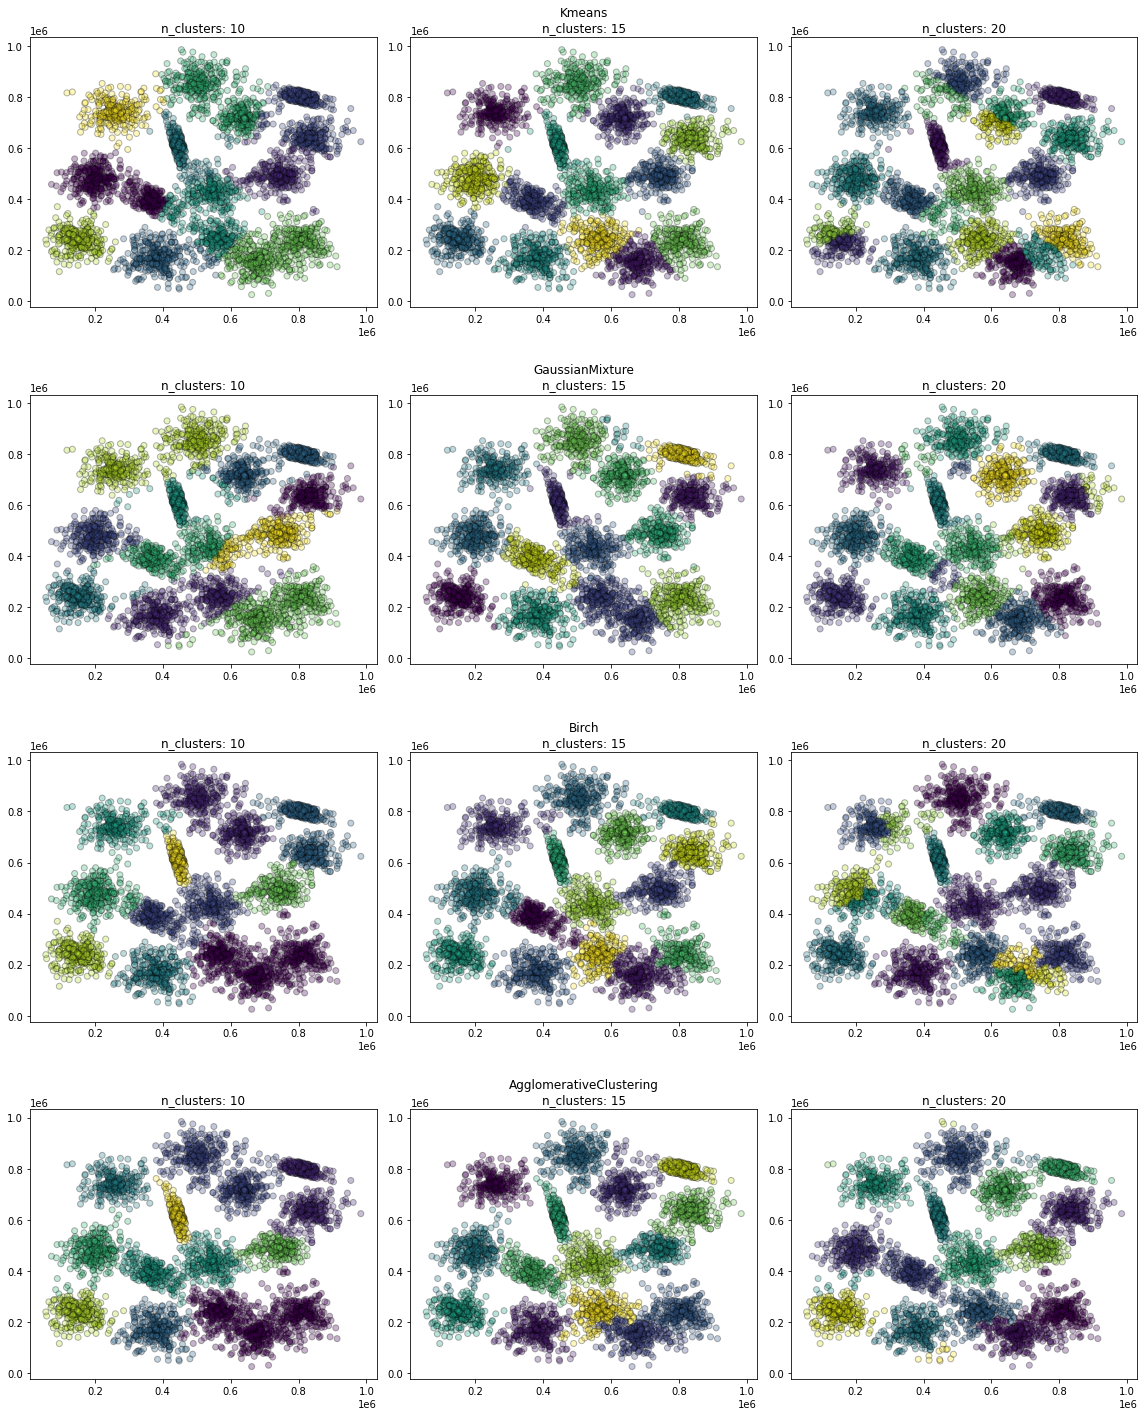

In [21]:
## BEGIN SOLUTION (do not delete this comment!)

def title_for_each_plot_row(fig: plt.Figure, grid: SubplotSpec, title: str):
  row = fig.add_subplot(grid)
  row.set_title(f'{title}\n')
  row.set_frame_on(False)
  row.axis('off')

algs = [KMeans(), GaussianMixture(), Birch(), AgglomerativeClustering()]

n_clusters = np.arange(10, 21)
all_pred = []

fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(16, 20))

for i, alg in enumerate(algs):
  alg.set_params(**(params_used[i]))

  for j, clusters in enumerate(n_clusters):
    if type(alg).__name__ != 'GaussianMixture':
      alg.set_params(**{'n_clusters': clusters})
    else:
      alg.set_params(**{'n_components': clusters})      

    pred = alg.fit_predict(points)
    all_pred.append(pred)
    
    if clusters == 10 or clusters == 15 or clusters == 20:
      ax[i, int(clusters/5 - 2)].scatter(points[:, 0], points[:, 1], c = pred, alpha = 0.3, edgecolor='k')
      ax[i, int(clusters/5 - 2)].set_title(f'n_clusters: {clusters}')

grid = plt.GridSpec(4, 3)
title_for_each_plot_row(fig, grid[0, ::], 'Kmeans')
title_for_each_plot_row(fig, grid[1, ::], 'GaussianMixture')
title_for_each_plot_row(fig, grid[2, ::], 'Birch')
title_for_each_plot_row(fig, grid[3, ::], 'AgglomerativeClustering')
fig.tight_layout()
fig.set_facecolor('w')

### END SOLUTION (do not delete this comment!)

2) For each number of clusters vizualize the clustering result, calculate the clustering metrics and plot them;


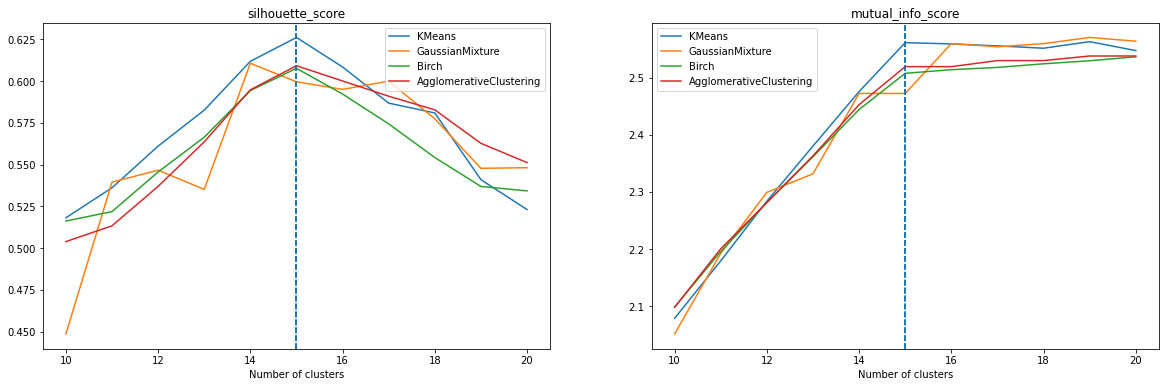

In [22]:
### BEGIN SOLUTION (do not delete this comment!)

silh_score_plot = []
mutual_info_plot = []

for i in range(len(algs) * len(n_clusters)):
  silh = silhouette_score(points, all_pred[i])
  silh_score_plot.append(silh)

  mutual_info = mutual_info_score(labels, all_pred[i])
  mutual_info_plot.append(mutual_info)

silh_score_plot = np.array(silh_score_plot).reshape((len(algs), len(n_clusters)))
mutual_info_plot = np.array(mutual_info_plot).reshape((len(algs), len(n_clusters)))

# Plot
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

for j in range(len(algs)):
  ax[0].plot(n_clusters, silh_score_plot[j, :], label = type(algs[j]).__name__)
  ax[0].axvline(x = 15, ls='--')
  ax[0].legend(loc='upper right')
  ax[0].set_title('silhouette_score')
  ax[0].set_xlabel('Number of clusters')

for k in range(len(algs)):
  ax[1].plot(n_clusters, mutual_info_plot[k, :], label = type(algs[k]).__name__)
  ax[1].axvline(x = 15, ls='--')
  ax[1].legend(loc='upper left')
  ax[1].set_title('mutual_info_score')
  ax[1].set_xlabel('Number of clusters')

### END SOLUTION (do not delete this comment!)

### Task 3.2. Finding the Number of Clusters with Bootstrap. (1 pt.)
For a chosen algorithm find the best number of clusters using bootstrap. Based on your observations made at the previous task, choose one algorithm assuming **you do not have true labels and do not know the true number of clusters**.
1. Estimate variance of the clustering metric of your choice (i.e. *silhouette score*/*mutual information*/*adjusted mutual information*)and construct normal 95% **confidence interval (CI)**;
2. **Plot the metric** with the corresponding confidence intervals and show the best number of clusters.

__Hints:__ 
- you can choose bootstrap samples with any size, and sample number starting from `50`;
- you can use `scipy.stats.norm.interval()` to derive CI;

1) Estimate variance of the clustering metric of your choice (i.e. silhouette score/mutual information/adjusted mutual information)and construct normal 95% confidence interval (CI);

In [23]:
### BEGIN SOLUTION (do not delete this comment!)

sample = 50
kmean_alg = KMeans()

mean_list = []
variance_list = []
conf_int = []

for i, clusters in enumerate(n_clusters): 
  silh = []
  kmean_alg.set_params(**{'n_clusters': clusters})

  for j in range(sample):
    new_data = np.random.choice(points.shape[0], points.shape[0], replace=True)
    pred_new_data = kmean_alg.fit_predict(points[new_data])
    silh.append(silhouette_score(points[new_data], pred_new_data))

  mean_list.append(np.mean(silh))
  variance_list.append(np.var(silh))
  conf_int.append(stats.norm.interval(alpha = 0.95, loc = mean_list[-1], scale = variance_list[-1]**(1/2)))

### END SOLUTION (do not delete this comment!)

2) Plot the metric with the corresponding confidence intervals and show the best number of clusters.

Number of clusters: 10
	Variance: 3.871226605404707e-05
	Confidence interval: (0.5067067555455363, 0.5310962267085096)

Number of clusters: 11
	Variance: 4.210537343285739e-05
	Confidence interval: (0.5248243717128375, 0.5502602564564253)

Number of clusters: 12
	Variance: 2.3938796618482432e-05
	Confidence interval: (0.553470584020366, 0.5726497290927484)

Number of clusters: 13
	Variance: 2.402857181014384e-05
	Confidence interval: (0.5735596513445003, 0.5927747255445921)

Number of clusters: 14
	Variance: 1.4555959581521034e-05
	Confidence interval: (0.6052390951694075, 0.620194511489671)

Number of clusters: 15
	Variance: 1.3271675817689158e-05
	Confidence interval: (0.6185910310863625, 0.6328714507069835)

Number of clusters: 16
	Variance: 2.6427163584775875e-05
	Confidence interval: (0.6008696599726513, 0.621020973642848)

Number of clusters: 17
	Variance: 3.694241475385122e-05
	Confidence interval: (0.5816031018220466, 0.605428530675599)

Number of clusters: 18
	Variance: 9.0672

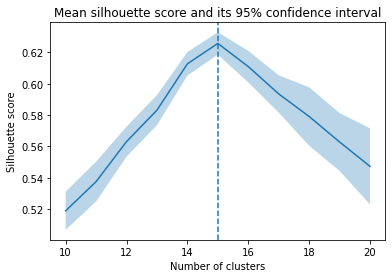

In [24]:
### BEGIN SOLUTION (do not delete this comment!)

for i, clusters in enumerate(n_clusters):
  print('Number of clusters: {}\n\tVariance: {}\n\tConfidence interval: {}\n'.format(clusters, variance_list[i], conf_int[i]))

lower_bound = []
upper_bound = []

for i in range(len(conf_int)):
  lower_bound.append(conf_int[i][0])
  upper_bound.append(conf_int[i][1])

plt.plot(n_clusters, mean_list)
plt.title('Mean silhouette score and its 95% confidence interval')
plt.axvline(x = 15, ls='--')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.fill_between(n_clusters, lower_bound, upper_bound, alpha = 0.3);

### END SOLUTION (do not delete this comment!)

## Task 4. Practice with Different Anomaly Detection Algorithms. (2 pts)

### Task 4.1 (1 pt)

- Here we will use __fraud_dataset__ (creditcard.csv )
- Compute the __contamination__ (or impurity) on the **test** set as the ratio of anomaly objects to all the objects.  
- Predict the anomaly with any **three** Anomaly detection methods among ones from: https://scikit-learn.org/stable/modules/outlier_detection.html, note, we do not use true labels to fit anomaly detectors.
- Explore, how the `roc_auc_score` for anomaly detectors changes with `contamination` value, taking a grid `[0.1*contamination, 1*contamination, 10*contamination]`. Point out the best performing algorithm.

In [ ]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score

data = pd.read_csv('creditcard.csv')

X = data.drop(columns="Class")
y = data["Class"]

# keep the split fixed
tt_split = train_test_split(X, y, test_size = 0.1, stratify=y, random_state= 42)
train_X, test_X, train_y, test_y = tt_split 

# delete the targets for training
train_y = 0

In [ ]:
### BEGIN SOLUTION (do not delete this comment!)
  
# impurity estimation on test data

contamination = np.mean(test_y)
print(f'Contamination on the test set: {contamination}')

### END SOLUTION (do not delete this comment!)

Contamination on the test set: 0.01693743518838576


In [ ]:
### BEGIN SOLUTION (do not delete this comment!)

algorithm = {'EllipticEnvelope': EllipticEnvelope(contamination=contamination, random_state=0),
             'IsolationForest': IsolationForest(contamination=contamination, bootstrap=True, random_state=0),              
             'LocalOutlierFactor': LocalOutlierFactor(contamination=contamination, novelty=True)}

for i in [0.1, 1, 10]:
  for key, value in algorithm.items():
    model = value.set_params(**{'contamination': contamination * i})
    
    model.fit(train_X)
    y_pred = model.predict(test_X)

    roc_auc = roc_auc_score(test_y, y_pred)
    precision = precision_score(test_y, y_pred, average="micro")

    print(f'{key}: Contamination: {contamination * i:.4f} ROC/AUC: {roc_auc:.4f} Precision: {precision:.4f}')

### END SOLUTION (do not delete this comment!)

EllipticEnvelope: Contamination: 0.0017 ROC/AUC: 0.5009 Precision: 0.0169
IsolationForest: Contamination: 0.0017 ROC/AUC: 0.4796 Precision: 0.0162
LocalOutlierFactor: Contamination: 0.0017 ROC/AUC: 0.5009 Precision: 0.0169
EllipticEnvelope: Contamination: 0.0169 ROC/AUC: 0.4880 Precision: 0.0162
IsolationForest: Contamination: 0.0169 ROC/AUC: 0.2273 Precision: 0.0076
LocalOutlierFactor: Contamination: 0.0169 ROC/AUC: 0.5003 Precision: 0.0166
EllipticEnvelope: Contamination: 0.1694 ROC/AUC: 0.2739 Precision: 0.0066
IsolationForest: Contamination: 0.1694 ROC/AUC: 0.1565 Precision: 0.0028
LocalOutlierFactor: Contamination: 0.1694 ROC/AUC: 0.4943 Precision: 0.0138


### Task 4.2 (1 pt)

The idea is to see when anomaly detection methods, trained with no labels, can facilitate the prediction of the classifier. Imagine a real case scenario: you have labelled only a small portion of the dataset and a bunch of unlabeled data. We will simulate the situation when __90%__ of data is unlabeled and we still desire to achieve good performance. 


As you can score your predictions only on the __10%__ of the sample, you better do it in cross validation to ensure the model stability.
1. Take your favorite classifier and estimate the performance on __test set__ using `StratifiedKFold(n_splits=10, random_state = 42)` with `roc_auc` and `precision_score`. You can use test set upsampling and other instruments to enforce your prediction. 

> Do not get confused, here we swap __train__ and __test__ and use __test__ as if it's the only data we have on our hands.

2. Try to enhance the classifier performance in  `roc_auc` or `precision_score` (or ideally both), building the ensemble, using __Anomaly detection__ methods from the previous task. You can fit __Anomaly detection__ methods on both  __training set__ and subset from __test set__ on the cross-validation fold.

__NOTE:__ try not to overfit, thus not adjust the `contamination` while training, and refit classifiers on each fold. 

__Hints:__ `sklearn.ensemble.VotingClassifier` does not support Anomaly detection methods, so you are to write it yourself. And `np.logical_and` or `np.logical_or` will suit for the trivial ensemble.

In [ ]:
### BEGIN SOLUTION (do not delete this comment!)

# choose your favorite classifier, e.g. from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=10, random_state = 42, shuffle=True)
skf.get_n_splits(test_X, test_y)

roc_auc_scores = [] 
pr_score = []

for train_index, test_index in skf.split(test_X, test_y):
    # >>> your solution here <<<

    lr = LogisticRegression()
    test_x_train = test_X.iloc[train_index]
    test_x_test = test_X.iloc[test_index]

    test_y_train = test_y.iloc[train_index]
    test_y_test = test_y.iloc[test_index]

    lr.fit(test_x_train, test_y_train)
    y_pred = lr.predict(test_x_test)

    roc_auc_scores.append(roc_auc_score(test_y_test, y_pred))
    pr_score.append(precision_score(test_y_test, y_pred))
    
print(f'ROC/AUC mean: {np.mean(roc_auc_scores)} std: {np.std(roc_auc_scores)}')    
print(f'Precision mean: {np.mean(pr_score)} std: {np.std(pr_score)}')
     
### END SOLUTION (do not delete this comment!)

ROC/AUC mean: 0.8684179639238943 std: 0.1005810267100324
Precision mean: 0.8371428571428572 std: 0.2141142170879451


Try to enhance the classifier performance using Anomaly detection methods

In [ ]:
### BEGIN SOLUTION (do not delete this comment!)

skf = StratifiedKFold(n_splits=10, random_state = 42, shuffle=True)
skf.get_n_splits(test_X, test_y)

roc_auc_scores = [] 
pr_score = []

#for train_index, test_index in skf.split(test_X, test_y):
    # >>> your solution here <<<

lr = LogisticRegression()

algorithm = [EllipticEnvelope(), IsolationForest()]

for train_index, test_index in skf.split(test_X, test_y):
  y_pred = []

  test_x_train = test_X.iloc[train_index]
  test_x_test = test_X.iloc[test_index]

  test_y_train = test_y.iloc[train_index]
  test_y_test = test_y.iloc[test_index]

  for alg in algorithm:
    alg.fit(test_x_train, test_y_train)

    y_pred_alg = np.array(alg.predict(test_x_test) < 0, dtype=int)  
    y_pred.append(y_pred_alg)
    
  lr.fit(test_x_train, test_y_train)
  y_pred_temp = lr.predict(test_x_test)
  y_pred.append(y_pred_temp)

  y_pred_all = np.array(np.logical_and(y_pred[2], np.logical_and(y_pred[0], y_pred[1]), dtype=int))

  roc_auc_scores.append(roc_auc_score(test_y_test, y_pred_all))
  pr_score.append(precision_score(test_y_test, y_pred_all))

print(f'ROC/AUC mean: {np.mean(roc_auc_scores)} std: {np.std(roc_auc_scores)}')    
print(f'Precision mean: {np.mean(pr_score)} std: {np.std(pr_score)}')
    
### END SOLUTION (do not delete this comment!)

ROC/AUC mean: 0.7625 std: 0.11685995892520244
Precision mean: 1.0 std: 0.0


Write 1-2 sentences on your findings.

*BEGIN SOLUTION (do not delete this comment!)*
When I use the classifier as Logistic Regression, the performance on the test set in case of ROC/AUC has the better result (higher score and lower deviation). After enhancing the classifier performance using Anomaly detection methods, the score of ROC/AUC slighly drops but precision score increases and can be interpret that Anomaly detection methods can improve the precision score of this data.

*END SOLUTION (do not delete this comment!)*